In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Input, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
import numpy as np

2025-03-24 18:56:08.433375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Data path
data_dir = "../Data"
train_dir = "../Data/train"
test_dir = "../Data/test"

# Image size and batch variable
img_height , img_weidth = 48 , 48
batch = 32

# Image Normalization to [0,1]
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )

# Note for the labes, the flow_from_directory assigns it according to the folder name
# Load training data
train_data = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_weidth),
    batch_size = batch,
    class_mode = 'categorical',
    subset = 'training'
)



validation_data = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_weidth),
    batch_size = batch,
    class_mode = 'categorical',
    subset='validation'
)

# Load test data
test_data = datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_weidth),
    batch_size = batch,
    class_mode = 'categorical',
)

# Handeling Data imbalance 
# Get the class labels from the training data
class_labels = train_data.class_indices  

# Get the class indices 
class_indices = list(class_labels.values())

# Compute class weights based on class distribution in the training data
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(class_indices), 
                                     y=train_data.classes) 

# Convert class weights into a dictionary format for TensorFlow
class_weight_dict = {i: weight for i, weight in zip(class_indices, class_weights)}

print(class_weight_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
{0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [6]:
# Verify the data and its lable
# Check the output summary
print("Class names:", train_data.class_indices)
print("Number of batches per epoch:", train_data.samples // batch) 
print("Image shape:", train_data.image_shape)  
print("Number of classes:", len(train_data.class_indices))  

Class names: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Number of batches per epoch: 717
Image shape: (48, 48, 3)
Number of classes: 7


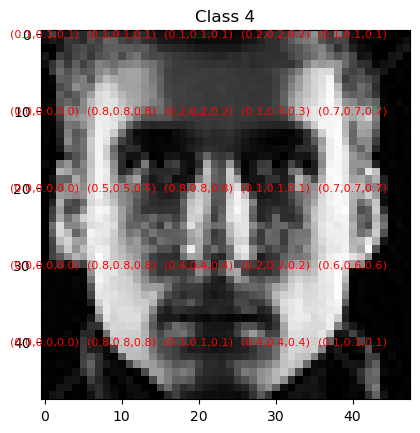

In [7]:
# Visualizing the image in its pixel value with 4 intervals

images , labels = next(train_data)
image = images[0]
label = labels[0]
c_value = np.argmax(label)

plt.imshow(image)
plt.title(f"Class {c_value}")

for i in range(0, img_height, 10):
    for j in range(0, img_weidth, 10):
        r, g, b = image[i, j]
        plt.text(j,i, f"({r:.1f},{g:.1f},{b:.1f})", color='red', fontsize=8, ha='center', va='center' )
plt.show()

Looking at the result of the model we can see that the model is overfitting as the traning accuracy after 10 epoch is 99.46% how ever the validation accuracy is at 45.01 %.

In [8]:
# intregrating convolution layers using pooling and drop out for over fitting
model = Sequential()

model.add(Input(shape=(img_height, img_weidth, 3)))
model.add(Conv2D(32, kernel_size= 3, activation='relu', padding='same' ))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size= 3, activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size= 3, activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))


# intregrating Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(7, activation='softmax'))
 
# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

In [9]:
# Stop the traing when accuracy and validation widens more then 0.1

class Overfitting(Callback):
    def __init__(self, threshold=0.1, patience=2):  
        super(Overfitting, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.counter = 0  

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if acc and val_acc:
            gap = acc - val_acc  
            print(f"\nEpoch {epoch+1}: Accuracy gap = {gap:.4f}")

            if gap > self.threshold:  
                self.counter += 1
                if self.counter >= self.patience:
                    print(f"\nStopping training: Accuracy gap exceeded {self.threshold} for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.counter = 0  

stop_overfitting = Overfitting(threshold=0.1, patience=2)

# Solwer the learning rate if the val_loss doen't improve in 3 epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

training = model.fit(train_data, epochs=20, validation_data = validation_data, callbacks=[reduce_lr, stop_overfitting], class_weight=class_weight_dict)


Epoch 1/20
718/718 [==============================] - ETA: 0s - loss: 1.9173 - accuracy: 0.1873
Epoch 1: Accuracy gap = -0.0058
718/718 [==============================] - 119s 165ms/step - loss: 1.9173 - accuracy: 0.1873 - val_loss: 1.9119 - val_accuracy: 0.1932 - lr: 5.0000e-04
Epoch 2/20
718/718 [==============================] - ETA: 0s - loss: 1.7586 - accuracy: 0.2951
Epoch 2: Accuracy gap = -0.0179
718/718 [==============================] - 144s 200ms/step - loss: 1.7586 - accuracy: 0.2951 - val_loss: 1.7338 - val_accuracy: 0.3130 - lr: 5.0000e-04
Epoch 3/20
718/718 [==============================] - ETA: 0s - loss: 1.6305 - accuracy: 0.3634
Epoch 3: Accuracy gap = -0.0010
718/718 [==============================] - 116s 162ms/step - loss: 1.6305 - accuracy: 0.3634 - val_loss: 1.6414 - val_accuracy: 0.3644 - lr: 5.0000e-04
Epoch 4/20
718/718 [==============================] - ETA: 0s - loss: 1.5108 - accuracy: 0.4113
Epoch 4: Accuracy gap = -0.0181
718/718 [=======================

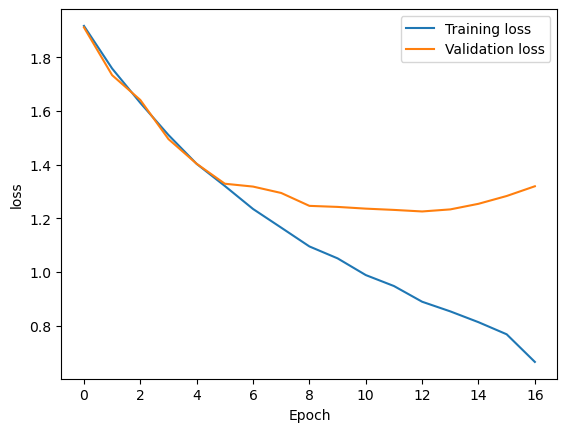

In [10]:
plt.plot(training.history['loss'], label= "Training loss")
plt.plot(training.history['val_loss'], label= "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

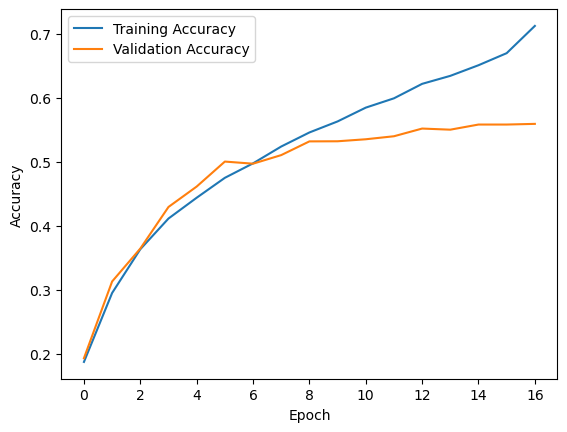

In [11]:
plt.plot(training.history['accuracy'], label="Training Accuracy")
plt.plot(training.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# the true test labels from data
y_true = test_data.classes  

# get predictions from model evaluation
# get predicted probabilities
y_pred_probs = model.predict(test_data, verbose=1)
# convert probabilities to labels
y_pred = np.argmax(y_pred_probs, axis=1)

# get accuracy score
accuracy = accuracy_score(y_true, y_pred)

# calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


225/225 [==============================] - 9s 38ms/step
Accuracy: 0.1764
Precision: 0.1747
Recall: 0.1764
F1 Score: 0.1746
